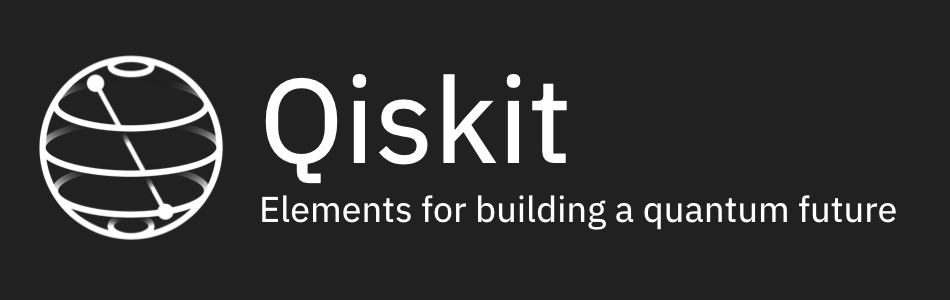

# The IBM Q Account

In Qiskit we have an interface for backends and jobs that is useful for running circuits and extending to third-party backends. In this tutorial, we will review the core components of Qiskit’s base backend framework, using the IBM Q account as an example.

The interface has four main components: the account, providers, backends, and jobs:

- **account**: Gives access to one or more ‘providers’ based on the account's permissions.

- **provider**: Provides access to quantum devices and simulators, collectively called ‘backends’, and additional services tailored to a specific backend instance.

- **backend**: A quantum device or simulator capable of running quantum circuits or pulse schedules.

- **job**: A local reference to a collection of quantum circuits or pulse schedules submitted to a given backend.

## Table of contents

1) [The Account](#account)


2) [The Provider](#provider)


3) [Backends](#backends)
    
    
4) [Jobs](#jobs)


5) [Updating from previous versions](#updating)

## The Account <a name='account'></a>

The Qiskit `IBMQ` account object is the local reference for accessing your IBM Q account, and all of the providers, backends, etc, that are available to you.

The `IBMQ` account has functions for handling administrative tasks. The credentials can be saved to disk, or used in a session and never saved.

- `enable_account(TOKEN)`: Enable your account in the current session.
- `save_account(TOKEN)`: Save your account to disk for future use.
- `load_account()`: Load account using stored credentials.
- `disable_account()`: Disable your account in the current session.
- `stored_account()`: List the account stored to disk.
- `active_account()`: List the account currently in the session.
- `delete_account()`: Delete the saved account from disk.



In order to access quantum devices, simulators, or other services, you must specify the source of these items by selecting a provider. To see all the providers available do the following:

In [1]:
from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

where we have assumed that the user has stored their IBMQ account information locally ahead of time using `IBMQ.save_account(TOKEN)`.

<div class="alert alert-block alert-info">
<b>Note:</b> The use of `provider` instances is the default way of retrieving backends from Qiskit 0.11 onwards - if you have been using earlier versions of Qiskit, check the <a href="#updating">"Updating from previous versions"</a> section for more detailed instructions on updating and using the different options.</div>
</div>

The above example shows two different providers. All `IBMQ` providers are specified by a `hub`, `group`, and `project`. The provider given by `hub='ibm-q', group='open', project='main'` is the provider that gives access to the public IBM Q devices available to all IQX users. The second is an example of a provider that is only unlocked for a specific set of users. Members of the IBM Q network may see one or more providers (with names different than those shown above) depending on the access level granted to them.

To access a given provider one should use the `get_provider()` method of the `IBMQ` account, filtering by `hub`, `group`, or `project`:

In [2]:
IBMQ.get_provider(hub='ibm-q')

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
IBMQ.get_provider(project='main')

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Finally, as a convenience, calling `IBMQ.load_account()` or `IBMQ.enable_account()` will return the default public provider instance `<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>`.

## The Provider <a name='provider'></a>

Providers accessed via the `IBMQ` account provide access to a group of different backends (for example, backends available through the IBM Q Experience or IBM Q Network quantum cloud services).

A provider inherits from `BaseProvider` and implements the methods:

- `backends()`: Returns all backend objects known to the provider.
- `get_backend(NAME)`: Returns the named backend.

Using the public provider instance from above:

In [4]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

Selecting a backend is done by name using the `get_backend(NAME)` method:

In [5]:
backend = provider.get_backend('ibmq_16_melbourne')
backend

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

### Filtering the Backends

You may also optionally filter the set of returned backends, by passing arguments that query the backend’s `configuration`, `status`, or `properties`. The filters are passed by conditions and, for more general filters, you can make advanced functions using a lambda function.

As a first example lets return only those backends that are real quantum devices, and that are currently operational:

In [6]:
provider.backends(simulator=False, operational=True)

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

Or, only those backends that are real devices, have more than 10 qubits, and are operational

In [7]:
provider.backends(filters=lambda x: x.configuration().n_qubits >= 10
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

[<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]

Lastly, show the least busy 5 qubit device (in terms of the number of jobs pending in the queue)

In [8]:
from qiskit.providers.ibmq import least_busy

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
least_busy(small_devices)

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

The above filters can be combined as desired.

## Backends <a name='backends'></a>

Backends represent either a simulator or a real quantum computer, and are responsible for running quantum circuits and/or pulse schedules and returning results. They have a `run` method which takes in a `qobj` as input, the Qiskit API serialization format, and returns a `BaseJob` object. This object allows asynchronous running of jobs for retrieving results from a backend when the job is completed.


At a minimum, backends use the following methods, inherited from `BaseBackend`:

- `provider()`: Returns the provider of the backend.
- `name()`: Returns the name of the backend.
- `status()`: Returns the current status of the backend.
- `configuration()`: Returns the backend configuration.
- `properties()`: Returns the backend properties.
- `run(QOBJ, **kwargs)`: Runs a qobj on the backend.


For remote backends they must support the additional methods:

- `jobs()`: Returns a list of previous jobs executed on this backend through the current provider instance.
- `retrieve_job(JOB_ID)`:  Returns a job by a job_id.

On a per device basis, the following commands may be supported:

- `defaults()`: Gives a data structure of typical default parameters.
- `schema()`: Gets a schema for the backend.

There are some "IBM Q backend"-only attributes:

- `hub`: The IBMQ hub for this backend.
- `group`:  The IBMQ group for this backend.
- `project`: The IBMQ project for this backend.


Lets load up the least busy backend from the `small_devices` filtered above:

In [9]:
backend = least_busy(small_devices)

Several examples using commands are:

In [10]:
backend.provider()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [11]:
backend.name()

'ibmqx2'

In [12]:
backend.status()

BackendStatus(backend_name='ibmqx2', backend_version='2.0.1', operational=True, pending_jobs=9, status_msg='active')

Here we see the name of the backend, the software version it is running, along with its operational status, number of jobs pending in the backends queue, and a more detailed status message.

Next we look at the backend configuration and properties:

In [13]:
backend.configuration()

QasmBackendConfiguration(allow_object_storage=True, allow_q_circuit=False, allow_q_object=True, backend_name='ibmqx2', backend_version='2.0.1', basis_gates=['u1', 'u2', 'u3', 'cx', 'id'], conditional=False, coupling_map=[[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]], credits_required=True, description='5 qubit device', gates=[GateConfig(coupling_map=[[0], [1], [2], [3], [4]], name='id', parameters=[], qasm_def='gate id q { U(0,0,0) q; }'), GateConfig(coupling_map=[[0], [1], [2], [3], [4]], name='u1', parameters=['lambda'], qasm_def='gate u1(lambda) q { U(0,0,lambda) q; }'), GateConfig(coupling_map=[[0], [1], [2], [3], [4]], name='u2', parameters=['phi', 'lambda'], qasm_def='gate u2(phi,lambda) q { U(pi/2,phi,lambda) q; }'), GateConfig(coupling_map=[[0], [1], [2], [3], [4]], name='u3', parameters=['theta', 'phi', 'lambda'], qasm_def='gate u3(theta,phi,lambda) q { U(theta,phi,lambda) q; }'), GateConfig(coupling_map=[[0, 1], [0, 2], [1, 0]

In [14]:
backend.properties()

BackendProperties(_gates={'id': {(0,): {'gate_error': (0.000726140677193839, datetime.datetime(2019, 12, 10, 10, 33, 6, tzinfo=datetime.timezone.utc)), 'gate_length': (3.555555555555556e-08, datetime.datetime(2019, 12, 10, 11, 36, 1, tzinfo=datetime.timezone.utc))}, (1,): {'gate_error': (0.0005317186576686104, datetime.datetime(2019, 12, 10, 10, 35, 39, tzinfo=datetime.timezone.utc)), 'gate_length': (3.555555555555556e-08, datetime.datetime(2019, 12, 10, 11, 36, 1, tzinfo=datetime.timezone.utc))}, (2,): {'gate_error': (0.00033232161794790807, datetime.datetime(2019, 12, 10, 10, 40, 13, tzinfo=datetime.timezone.utc)), 'gate_length': (3.555555555555556e-08, datetime.datetime(2019, 12, 10, 11, 36, 1, tzinfo=datetime.timezone.utc))}, (3,): {'gate_error': (0.00047241207684760875, datetime.datetime(2019, 12, 10, 10, 42, 46, tzinfo=datetime.timezone.utc)), 'gate_length': (3.555555555555556e-08, datetime.datetime(2019, 12, 10, 11, 36, 1, tzinfo=datetime.timezone.utc))}, (4,): {'gate_error': (0

To see the last five jobs run on this backend:

In [15]:
for ran_job in backend.jobs(limit=5):
    print(str(ran_job.job_id()) + " " + str(ran_job.status()))

5defff4311c7870011fd5efc JobStatus.DONE
5defbcfe286f820011720766 JobStatus.DONE
5defb894a6564c0011ca6f93 JobStatus.DONE
5defb84f286f82001172074b JobStatus.DONE
5deea121286f8200117200a9 JobStatus.DONE


A `job` can be retrieved using the `retrieve_job(JOB_ID)` method:

In [16]:
job = backend.retrieve_job(ran_job.job_id())

## Jobs <a name='jobs'></a>

Job instances can be thought of as the “ticket” for a submitted job. They find out the execution state at a given point in time (for example, if the job is queued, running, or has failed), and also allow control over the job. They have the following methods:

- `status()`: Returns the status of the job.
- `backend()`: Returns the backend the job was run on.
- `job_id()`: Gets the job_id.
- `cancel()`: Cancels the job.
- `result()`: Gets the results from the circuit run.

"IBM Q job"-only functions include:

- `creation_date()`: Gives the date at which the job was created.
- `queue_position()`: Returns the position of the job in the queue.
- `error_message()`: The error message of failed jobs, if any.

Let's start with the `status()`. This returns the job status and a message:

In [17]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

To get a backend object from the job, use the `backend()` method:

In [18]:
backend_temp = job.backend()
backend_temp

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

To get the job_id use the `job_id()` method:

In [19]:
job.job_id()

'5deea121286f8200117200a9'

To get the result from the job, use the `result()` method:

In [20]:
result = job.result()
counts = result.get_counts()
print(counts)

{'00001': 24, '00010': 15, '00011': 536, '00000': 449}


If you want to check the creation date, use `creation_date()`:

In [21]:
job.creation_date()

'2019-12-09T19:31:45.175000Z'

Let's make an active example.

In [22]:
from qiskit import *
from qiskit.compiler import transpile, assemble

In [23]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)
circuit.x(qr[0])
circuit.x(qr[1])
circuit.ccx(qr[0], qr[1], qr[2])
circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)

To pass this circuit to the backend, we must first map it onto the backend, package it, and send to the device.  This is all done for you by the `execute` function:

In [24]:
job = execute(circuit, backend)

Alternatively, you can map the circuit yourself using the `transpile` function, package it using `assemble`, and then send it from the `backend` instance itself:

In [25]:
mapped_circuit = transpile(circuit, backend=backend)
qobj = assemble(mapped_circuit, backend=backend, shots=1024)
job = backend.run(qobj)

This second method is discussed in more detail in [Part 5: Using the Transpiler](5_using_the_transpiler.ipynb).

## Job Manager <a name='job manager'></a>

`qiskit-ibmq-provider` version `0.4` (`Qiskit` version `0.14`) introduced a new Job Manager (`IBMQJobManager`), as a higher-level mechanism for handling jobs composed of multiple circuits or pulse schedules. The Job Manager splits the experiments into multiple jobs based on backend restrictions. When the jobs are finished, it collects and presents the results in a unified view.

`IBMQJobManager` has the following methods:
- `run()`: Execute a set of circuits or pulse schedules.
- `report()`: Return a report on the statuses of all jobs managed by this manager.
- `job_sets()`: Return a list of managed job sets matching the specified filtering.

You can run multiple sets of experiments by invoking `job_manager.run()` multiple times, and each call will return a `ManagedJobSet` instance. A `ManagedJobSet`, as the name implies, is a set of managed jobs. It has similiar methods as the Job class:
- `statuses()`: Return the status of each job.
- `cancel()`: Cancel all managed jobs in this set.
- `results()`: Return the results of the jobs.
- `error_messages()`: Provide details about job failures.
- `jobs()`: Return a list of submitted jobs.
- `report()`: Return a report on current job statuses.

Now let's see some examples. Say you want to submit a bunch of circuits to a backend:

In [26]:
from qiskit.providers.ibmq.managed import IBMQJobManager

sim_backend = provider.get_backend('ibmq_qasm_simulator')
# Prepare a set of circuits
circs = []
for _ in range(20):
    circs.append(circuit)
circs = transpile(circs, backend=sim_backend)

# Submit them all to the backend
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(circs, backend=sim_backend, name='foo')

You can use the `report()` method to inquire the statuses of the jobs:

In [27]:
print(job_set_foo.report())

Job set foo:
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-19
    job index: 0
    job ID: 5dcb15332592de0011c93232
    name: foo_0_
    status: job is being validated


`job_set_foo` above is not very interesting, as it only contains a single job. To force multiple jobs without making this tutorial too slow, we can use the `max_experiments_per_job` parameter:

In [28]:
# Submit them all to the backend
job_set_bar = job_manager.run(circs, backend=sim_backend, name='bar', max_experiments_per_job=10)

In [29]:
print(job_set_bar.report())

Job set bar:
Summary report:
       Total jobs: 2
  Successful jobs: 2
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 0

Detail report:
  experiments: 0-9
    job index: 0
    job ID: 5dcb153ef2b4ea00116071ba
    name: bar_0_
    status: job has successfully run
  experiments: 10-19
    job index: 1
    job ID: 5dcb153e1896660011bb286f
    name: bar_1_
    status: job has successfully run


As you can see, `job_set_bar` contains multiple jobs. To collect the results of all jobs, you can use `job_set.results()`, which returns a `ManagedResults` instance. `ManagedResults` supports the same methods as `Result`, which can be used to retrieve the ouputs of individual experiments:

In [30]:
results = job_set_bar.results()
print("This is the histogram data for experiment 5: {}".format(results.get_counts(5)))
print("This is the histogram data for experiment 15: {}".format(results.get_counts(15)))

This is the histogram data for experiment 5: {'101': 1024}
This is the histogram data for experiment 15: {'101': 1024}


Job Manager currently only supports new jobs, which means you cannot retrieve a `ManagedResults` instance for past jobs once the session is closed. You can, however, save the job IDs and use the traditional `backend.retrieve_job()` to retrive the jobs and their results.

You can use `job_set.jobs()` to retrieve a list of jobs within the job set. Note that an entry is `None` if that particular job could not be submitted.

In [31]:
jobs = job_set_bar.jobs()  # Get a list of all jobs in the set.
job0 = jobs[0]
if job0 is None:
    print("Job0 submit failed!")

## Updating from previous versions <a name='updating'></a>

Since `Qiskit` version `0.11`, the IBM Q account defaults to using the new [IBM Q Experience](https://quantum-computing.ibm.com), which supersedes the legacy Quantum Experience and Q-console.

If you have credentials for the legacy Quantum Experience or Q-console stored in disk, you can make use of the `IBMQ.update_account()` helper function that converts legacy credentials to the new APIv2 format:

In [32]:
# IBMQ.update_account()

You can find more information on how to update your programs in the [README.md](https://github.com/Qiskit/qiskit-ibmq-provider/blob/master/README.md#updating-to-the-new-ibm-q-experience) file in the provider repository.

In [33]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright